In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import seaborn as sns
import numpy as np
from autorank import autorank, plot_stats, create_report
from util import  get_all_linear_evaluation_results, clean_linear_probing_results, pivot_linear_probing_results, get_best_performing_per_metric, get_pivot_table_for_q1

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ['DejaVu Serif', 'Bitstream Vera Serif', 'Computer Modern Roman', 'New Century Schoolbook', 'Century Schoolbook L', 'Utopia', 'ITC Bookman', 'Bookman', 'Nimbus Roman No9 L', 'Palatino', 'Charter', 'serif'],
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.title_fontsize": 12,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "lines.linewidth": 2,
    "lines.markersize": 6,
    "legend.frameon": False,
    "figure.figsize": (9, 3)  # standard size for subplots
})
COLORS = ['#4c90b8', '#2ac3c1', '#f5b811', '#de653e', '#ff912a']
color_dict = {
    'BaselineAll': 'black',
    'BaselineNone': 'gray',
    'DisagreementSampling(DT)': COLORS[3],
    'DisagreementSampling(DS)': COLORS[4],
    'RandomSampling': COLORS[0],
    # add other sampling methods as needed
}

# 0. Load Results Data

In [6]:
base_results_folder = "all_results"


In [7]:
final_clustering_df, final_linear_probing_df = get_all_linear_evaluation_results(base_results_folder)
final_clustering_df, final_linear_probing_df = clean_linear_probing_results(final_clustering_df, final_linear_probing_df)

In [8]:
# Pivot table with baselines

join_keys = ['dataset', 'seed', 'n_labeled', 'metric', 'model']

linear_performance_pivot = pivot_linear_probing_results(final_linear_probing_df, join_keys)

# Average across seeds
average_performance_per_seed = linear_performance_pivot.groupby(['dataset', 'n_labeled', 'n_sample', 'sampling_method', 'metric', 'bracket', 'model'])[['value', 'baseline_none', 'baseline_all', 'baseline_raw_features']].mean().reset_index()

best_performance_per_bracket = get_best_performing_per_metric(average_performance_per_seed,
                                                 aggregation_group=['dataset', 'n_labeled', 'sampling_method', 'n_sample'],
                                                 metric='auprc_macro_test')

best_performance_per_nunlabeled_and_bracket = get_best_performing_per_metric(average_performance_per_seed,
                                                 aggregation_group=['dataset', 'n_labeled', 'sampling_method'],
                                                 metric='auprc_macro_test')

## 1. Is the embedding space more linearly separable if pretrained on all vs sampled vs none unlabeled examples?

In [9]:
q1_df = best_performance_per_nunlabeled_and_bracket.copy()

# calculate percentages
q1_df['of_baseline_all'] = (q1_df['value'] / q1_df['baseline_all'])*100
q1_df['of_baseline_none'] = (q1_df['value'] / q1_df['baseline_none'])*100
q1_df['of_baseline_raw'] = (q1_df['value'] / q1_df['baseline_raw_features'])*100
q1_df['none_of_all'] = (q1_df['baseline_none'] / q1_df['baseline_all'])*100

In [10]:
value_columns = ['of_baseline_all', 'of_baseline_none', 'none_of_all', 'of_baseline_raw']
q1_answer = get_pivot_table_for_q1(q1_df, value_columns, aggregation='mean')
q1_answer

% Of Baseline All % Of Baseline None  \
n_labeled sampling_method                                                 
50        DisagreementSampling(DS)               105                107   
          DisagreementSampling(DT)               104                106   
          RandomSampling                         103                104   
100       DisagreementSampling(DS)               103                106   
          DisagreementSampling(DT)               104                107   
          RandomSampling                         101                104   
150       DisagreementSampling(DS)               105                106   
          DisagreementSampling(DT)               105                106   
          RandomSampling                         103                104   
200       DisagreementSampling(DS)               101                104   
          DisagreementSampling(DT)               101                104   
          RandomSampling                          99                102   
350       DisagreementSampling(DS)               102                104   
          DisagreementSampling(DT)               103                105   
          RandomSampling                         100                102   
500       DisagreementSampling(DS)               102                106   
          DisagreementSampling(DT)               103                107   
          RandomSampling                         101                105   
750       DisagreementSampling(DS)                99                105   
          DisagreementSampling(DT)                99                105   
          RandomSampling                          98                104   
1000      DisagreementSampling(DS)                97                104   
          DisagreementSampling(DT)                96                104   
          RandomSampling                          95                103   

                                   % None Of All % Of Baseline Raw  
n_labeled sampling_method                                           
50        DisagreementSampling(DS)            99                69  
          DisagreementSampling(DT)            99                69  
          RandomSampling                      99                68  
100       DisagreementSampling(DS)            97                68  
          DisagreementSampling(DT)            97                69  
          RandomSampling                      97                67  
150       DisagreementSampling(DS)            98                68  
          DisagreementSampling(DT)            98                68  
          RandomSampling                      98                67  
200       DisagreementSampling(DS)            97                67  
          DisagreementSampling(DT)            97                67  
          RandomSampling                      97                67  
350       DisagreementSampling(DS)            98                67  
          DisagreementSampling(DT)            98                68  
          RandomSampling                      98                67  
500       DisagreementSampling(DS)            95                68  
          DisagreementSampling(DT)            95                68  
          RandomSampling                      95                67  
750       DisagreementSampling(DS)            94                68  
          DisagreementSampling(DT)            94                68  
          RandomSampling                      94                67  
1000      DisagreementSampling(DS)            92                68  
          DisagreementSampling(DT)            92                68  
          RandomSampling                      92                67

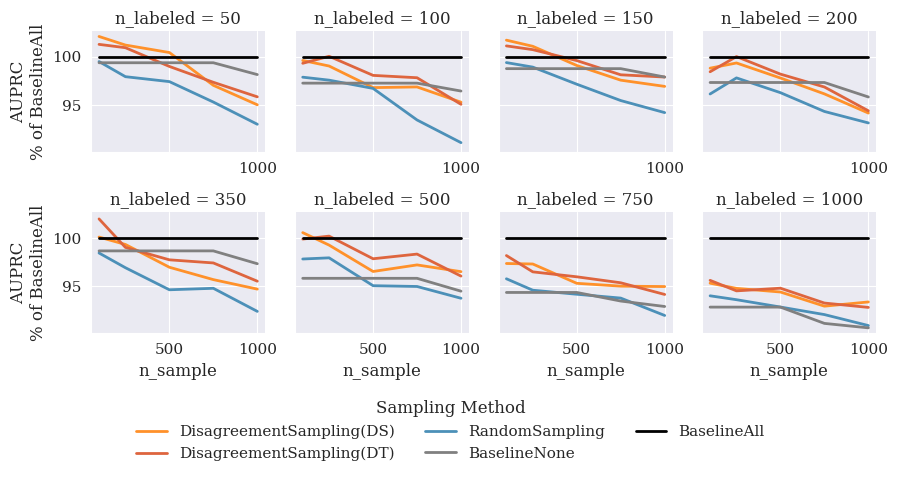

In [14]:
# Start from the best_performance_per_bracket DataFrame
df_plot = best_performance_per_bracket.copy()
df_plot['% of BaselineAll'] = 100 * df_plot['value'] / df_plot['baseline_all']
df_plot['sampling_method'] = df_plot['sampling_method'].astype(str)

# BaselineNone line
df_none = df_plot[['n_sample', 'n_labeled', 'baseline_none', 'baseline_all']].copy()
df_none['% of BaselineAll'] = 100 * df_none['baseline_none'] / df_none['baseline_all']
df_none['sampling_method'] = 'BaselineNone'
df_none = df_none[['n_sample', 'n_labeled', 'sampling_method', '% of BaselineAll']]

# BaselineAll line
df_all = df_plot[['n_sample', 'n_labeled']].drop_duplicates().copy()
df_all['% of BaselineAll'] = 100
df_all['sampling_method'] = 'BaselineAll'
df_all = df_all[['n_sample', 'n_labeled', 'sampling_method', '% of BaselineAll']]

# # BaselineRawFeatures line
# df_raw = best_performance_per_bracket[['n_sample', 'n_labeled', 'baseline_raw_features', 'baseline_all']].copy()
# df_raw['% of BaselineAll'] = 100 * df_raw['baseline_raw_features'] / df_raw['baseline_all']
# df_raw['sampling_method'] = 'BaselineRawFeatures'
# df_raw = df_raw[['n_sample', 'n_labeled', 'sampling_method', '% of BaselineAll']]

# Concatenate all lines
df_plot = pd.concat([
    df_plot[['n_sample', 'n_labeled', 'sampling_method', '% of BaselineAll']],
    df_none,
    df_all,
    # df_raw
], ignore_index=True)

color_dict = {
    'BaselineAll': 'black',
    'BaselineNone': 'gray',
    # 'BaselineRawFeatures': '#9467bd',  # purple
    'DisagreementSampling(DT)': COLORS[3],
    'DisagreementSampling(DS)': COLORS[4],
    'RandomSampling': COLORS[0],
    # add other sampling methods as needed
}

# Plot
g = sns.relplot(
    data=df_plot,
    x='n_sample',
    y='% of BaselineAll',
    hue='sampling_method',
    col='n_labeled',
    kind='line',
    palette=color_dict,
    facet_kws={'sharey': True, 'sharex': True},
    col_wrap=4,
    errorbar=None,
    height=2, aspect=0.8,
)

g.set_axis_labels('n_sample', 'AUPRC\n% of BaselineAll')

# Force legend creation if missing
g._legend.remove()
g._legend = g.fig.legend(
    handles=g._legend_data.values(),
    labels=g._legend_data.keys(),
    title='Sampling Method',
    loc='lower center',
    bbox_to_anchor=(0.5, -0.2),
    ncol=3,
    frameon=False
)

plt.subplots_adjust(bottom=0.25)  # Adjust space to make room
plt.tight_layout()
plt.savefig('plots/1_2_nsample_split_by_nlabeled_embedding_space.pdf', bbox_inches='tight')
plt.show()

